## Step 0: Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. 

## Step 1: Load the dataset

The dataset we'll use is a list of over one million news headlines published over a period of 15 years. We'll start by loading it from the `abcnews-date-text.csv` file.

In [13]:
'''
Load the dataset from the CSV and save it to 'data_text'
'''
import pandas as pd
data = pd.read_csv('npr.csv',encoding='latin-1', error_bad_lines=False);
print(data.head())

  id                        page_id             name   .1  \
0    _  10643211755_255251391226420      10643211755        
1    _  10643211755_388881894474609      10643211755        
2    _  10643211755_414455961905074      10643211755        
3    _  10643211755_284468938293046      10643211755        
4    _  10643211755_242967482460231      10643211755        

                                             message   .2 description   .3  \
0   From KPLU: Why most people get divorced in March                         
1  How Do You Ship A Horse To The London Olympics...                         
2  Unmarked: Ordinary Scenes With Unsettling Stories                         
3  The Three Little Pigs And The Future Of Journa...                         
4   Double Take 'Toons: Close Enough For Govt. Work?                         

                                             caption  ... link   .16  \
0  Divorce is a nasty business and this time of t...  ...    0         
1  The elite athlete

C:\Users\lveys\anaconda3\envs\nlp_py37\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,19,21,23,25,27,29,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# We only need the Headlines text column from the data
data_text = data[['caption']];
data_text['index'] = data_text.index

documents = data_text

C:\Users\lveys\anaconda3\envs\nlp_py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's glance at the dataset:

In [17]:
'''
Get the total number of documents
'''
print(len(documents))

36299


In [18]:
documents[:5]

,caption,index
0,Divorce is a nasty business and this time of t...,0
1,The elite athletes who travel to London for th...,1
2,These photos seem like perfectly quiet Ñ beaut...,2
3,In an action-packed two-minute remake of the...,3
4,Mitt Romney won six of 10 states on Super Tues...,4


## Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [21]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [22]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lveys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [23]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [26]:
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [24]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            # TODO: Apply lemmatize_stemming() on the token, then add to the results list
            result.append(lemmatize_stemming(token))
            
    return result



In [19]:
'''
Preview a document after preprocessing
'''
document_num = 4310
doc_sample = documents[documents['index'] == document_num].values[0][0]

doc_sample

'Fairness Campaign Director Chris Hartman left at about 11:30 p.m. and discovered that his car parked near the Ali Center had been sideswiped while parked on the streetÑthe mirror damaged   the side dented and scratched. He called Louisville Metro Police to file an accident report.Officers noticed mor...'

In [27]:
print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['Fairness', 'Campaign', 'Director', 'Chris', 'Hartman', 'left', 'at', 'about', '11:30', 'p.m.', 'and', 'discovered', 'that', 'his', 'car', 'parked', 'near', 'the', 'Ali', 'Center', 'had', 'been', 'sideswiped', 'while', 'parked', 'on', 'the', 'streetÑthe', 'mirror', 'damaged', '', '', 'the', 'side', 'dented', 'and', 'scratched.', 'He', 'called', 'Louisville', 'Metro', 'Police', 'to', 'file', 'an', 'accident', 'report.Officers', 'noticed', 'mor...']


Tokenized and lemmatized document: 
['fair', 'campaign', 'director', 'chris', 'hartman', 'leav', 'discov', 'park', 'near', 'center', 'sideswip', 'park', 'streetñth', 'mirror', 'damag', 'dent', 'scratch', 'call', 'louisvill', 'metro', 'polic', 'file', 'accid', 'report', 'offic', 'notic']


In [28]:
doc_sample = 'the doctor came to the village to visit some patients yesterday.'
print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['the', 'doctor', 'came', 'to', 'the', 'village', 'to', 'visit', 'some', 'patients', 'yesterday.']


Tokenized and lemmatized document: 
['doctor', 'come', 'villag', 'visit', 'patient', 'yesterday']


In [29]:
documents

,caption,index
0,Divorce is a nasty business and this time of t...,0
1,The elite athletes who travel to London for th...,1
2,These photos seem like perfectly quiet Ñ beaut...,2
3,In an action-packed two-minute remake of the...,3
4,Mitt Romney won six of 10 states on Super Tues...,4
...,...,...
36294,,36294
36295,Millions of Americans will vote for the next U...,36295
36296,From the waste-not ethos behind Angel Food Cak...,36296
36297,The high cost of child care is a strain for ma...,36297


Let's now preprocess all the news headlines we have. To do that, let's use the [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function from pandas to apply `preprocess()` to the `headline_text` column

**Note**: This may take a few minutes (it take 6 minutes on my laptop)

In [42]:
# TODO: preprocess all the headlines, saving the list of results as 'processed_docs'
processed_docs = documents['caption'].map(lambda x: preprocess(x))

In [43]:
'''
Preview 'processed_docs'
'''
processed_docs[:10]

0    [divorc, nasti, busi, time, year, busi, boom, ...
1    [elit, athlet, travel, london, summer, olymp, ...
2    [photo, like, perfect, quiet, beauti, landscap...
3    [action, pack, minut, remak, classic, tale, gu...
4    [mitt, romney, state, super, tuesday, accord, ...
5    [hashtag, term, stopkoni, trend, twitter, redd...
6    [realiti, invent, mind, truth, grasp, question...
7    [princeton, religi, scholar, elain, pagel, put...
8    [eject, huge, solar, flare, tuesday, nasa, say...
9    [eat, lot, fruit, veggi, give, skin, slight, y...
Name: caption, dtype: object

## Step 3.1: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [44]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [45]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 boom
1 busi
2 divorc
3 file
4 kplu
5 look
6 march
7 nasti
8 peak
9 reason
10 time


In [46]:
print(dictionary)

Dictionary(24229 unique tokens: ['boom', 'busi', 'divorc', 'file', 'kplu']...)


In [47]:
from collections import Counter
count = Counter()
for doc in processed_docs:
    for word in doc:
        count[word]+=1
print(count)

Counter({'say': 3383, 'year': 3246, 'peopl': 2058, 'like': 1680, 'state': 1623, 'time': 1529, 'help': 1311, 'world': 1230, 'american': 1223, 'work': 1202, 'citi': 1174, 'come': 1132, 'live': 1105, 'know': 1043, 'week': 1010, 'chang': 986, 'school': 972, 'music': 963, 'nation': 945, 'look': 936, 'countri': 936, 'take': 923, 'stori': 915, 'presid': 877, 'food': 846, 'research': 832, 'women': 827, 'book': 818, 'health': 809, 'life': 801, 'report': 800, 'want': 795, 'go': 773, 'call': 773, 'studi': 755, 'student': 755, 'think': 735, 'home': 729, 'tell': 720, 'long': 718, 'high': 678, 'play': 668, 'famili': 667, 'make': 644, 'turn': 626, 'recent': 616, 'group': 600, 'trump': 596, 'million': 591, 'song': 589, 'public': 587, 'leav': 578, 'show': 573, 'talk': 572, 'right': 563, 'hous': 560, 'includ': 557, 'polic': 555, 'month': 553, 'compani': 549, 'near': 546, 'question': 542, 'get': 542, 'start': 541, 'scientist': 534, 'need': 532, 'grow': 530, 'critic': 523, 'tri': 522, 'young': 517, 'polit

In [48]:
print(count['communiti'])

368


In [49]:
len(count)

24229

** Gensim filter_extremes **

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [50]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
# TODO: apply dictionary.filter_extremes() with the parameters mentioned above
dictionary.filter_extremes(no_below=10, no_above=0.1, keep_n=100000)

In [51]:
len(dictionary)

4868

** Gensim doc2bow **

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [52]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
# TODO
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [53]:
'''
Checking Bag of Words corpus for our sample document --> (token_id, token_count)
'''
bow_corpus[document_num]

[(3, 1),
 (59, 1),
 (164, 1),
 (211, 1),
 (237, 1),
 (256, 1),
 (287, 1),
 (659, 1),
 (903, 1),
 (998, 1),
 (1076, 1),
 (1257, 1),
 (1264, 2),
 (1377, 1),
 (1397, 1),
 (1404, 1),
 (1636, 1),
 (2221, 1),
 (3051, 1),
 (3982, 1),
 (4192, 1)]

In [54]:
'''
Preview BOW for our sample preprocessed document
'''
# Here document_num is document number 4310 which we have checked in Step 2
bow_doc_4310 = bow_corpus[document_num]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 3 ("file") appears 1 time.
Word 59 ("chris") appears 1 time.
Word 164 ("fair") appears 1 time.
Word 211 ("offic") appears 1 time.
Word 237 ("report") appears 1 time.
Word 256 ("accid") appears 1 time.
Word 287 ("near") appears 1 time.
Word 659 ("notic") appears 1 time.
Word 903 ("leav") appears 1 time.
Word 998 ("campaign") appears 1 time.
Word 1076 ("scratch") appears 1 time.
Word 1257 ("call") appears 1 time.
Word 1264 ("park") appears 2 time.
Word 1377 ("polic") appears 1 time.
Word 1397 ("center") appears 1 time.
Word 1404 ("discov") appears 1 time.
Word 1636 ("director") appears 1 time.
Word 2221 ("mirror") appears 1 time.
Word 3051 ("damag") appears 1 time.
Word 3982 ("louisvill") appears 1 time.
Word 4192 ("metro") appears 1 time.


## Step 3.2: TF-IDF on our document set ##

While performing TF-IDF on the corpus is not necessary for LDA implemention using the gensim model, it is recemmended. TF-IDF expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality.

*Please note: The author of Gensim dictates the standard procedure for LDA to be using the Bag of Words model.*

** TF-IDF stands for "Term Frequency, Inverse Document Frequency".**

* It is a way to score the importance of words (or "terms") in a document based on how frequently they appear across multiple documents.
* If a word appears frequently in a document, it's important. Give the word a high score. But if a word appears in many documents, it's not a unique identifier. Give the word a low score.
* Therefore, common words like "the" and "for", which appear in many documents, will be scaled down. Words that appear frequently in a single document will be scaled up.

In other words:

* TF(w) = `(Number of times term w appears in a document) / (Total number of terms in the document)`.
* IDF(w) = `log_e(Total number of documents / Number of documents with term w in it)`.

** For example **

* Consider a document containing `100` words wherein the word 'tiger' appears 3 times. 
* The term frequency (i.e., tf) for 'tiger' is then: 
    - `TF = (3 / 100) = 0.03`. 

* Now, assume we have `10 million` documents and the word 'tiger' appears in `1000` of these. Then, the inverse document frequency (i.e., idf) is calculated as:
    - `IDF = log(10,000,000 / 1,000) = 4`. 

* Thus, the Tf-idf weight is the product of these quantities: 
    - `TF-IDF = 0.03 * 4 = 0.12`.

In [55]:
'''
Create tf-idf model object using models.TfidfModel on 'bow_corpus' and save it to 'tfidf'
'''
from gensim import corpora, models

# TODO
tfidf = models.TfidfModel(bow_corpus)

In [56]:
'''
Apply transformation to the entire corpus and call it 'corpus_tfidf'
'''
# TODO
corpus_tfidf = tfidf[bow_corpus]

In [57]:
'''
Preview TF-IDF scores for our first document --> --> (token_id, tfidf score)
'''
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.264297812632815),
 (1, 0.37954405884131387),
 (2, 0.6028976647581494),
 (3, 0.24253422171819408),
 (4, 0.15057755593929345),
 (5, 0.24382024965899216),
 (6, 0.30926971466817804),
 (7, 0.28426203572072173),
 (8, 0.21632649917264085),
 (9, 0.1316515495376279),
 (10, 0.20268367018852831)]


## Step 4.1: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

** We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.
* **alpha** and **eta** are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is `1/num_topics`)
    - Alpha is the per document topic distribution.
        * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
        * Low alpha: Every document has a mixture of very few topics

    - Eta is the per topic word distribution.
        * High eta: Each topic has a mixture of most words(topics appear similar to each other).
        * Low eta: Each topic has a mixture of few words.

* ** passes ** is the number of training passes through the corpus. For  example, if the training corpus has 50,000 documents, chunksize is  10,000, passes is 2, then online training is done in 10 updates: 
    * `#1 documents 0-9,999 `
    * `#2 documents 10,000-19,999 `
    * `#3 documents 20,000-29,999 `
    * `#4 documents 30,000-39,999 `
    * `#5 documents 40,000-49,999 `
    * `#6 documents 0-9,999 `
    * `#7 documents 10,000-19,999 `
    * `#8 documents 20,000-29,999 `
    * `#9 documents 30,000-39,999 `
    * `#10 documents 40,000-49,999` 

In [62]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dictionary, passes = 50)

In [63]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.015*"year" + 0.012*"stori" + 0.012*"book" + 0.010*"film" + 0.010*"say" + 0.009*"life" + 0.007*"star" + 0.007*"world" + 0.006*"play" + 0.006*"movi"


Topic: 1 
Words: 0.015*"year" + 0.014*"health" + 0.013*"peopl" + 0.012*"care" + 0.009*"percent" + 0.007*"famili" + 0.007*"countri" + 0.007*"worker" + 0.007*"patient" + 0.007*"million"


Topic: 2 
Words: 0.021*"research" + 0.019*"studi" + 0.015*"peopl" + 0.013*"help" + 0.012*"say" + 0.012*"scientist" + 0.011*"like" + 0.010*"find" + 0.010*"human" + 0.008*"diseas"


Topic: 3 
Words: 0.023*"say" + 0.012*"court" + 0.012*"feder" + 0.011*"govern" + 0.011*"state" + 0.010*"case" + 0.007*"prison" + 0.007*"rule" + 0.007*"report" + 0.006*"year"


Topic: 4 
Words: 0.020*"polic" + 0.017*"say" + 0.015*"shoot" + 0.014*"offic" + 0.013*"attack" + 0.013*"year" + 0.011*"kill" + 0.010*"peopl" + 0.009*"week" + 0.007*"media"


Topic: 5 
Words: 0.025*"presid" + 0.021*"trump" + 0.015*"clinton" + 0.014*"state" + 0.014*"campaign" + 0.013*"polit" +

### Classification of the topics ###

Using the words in each topic and their corresponding weights, what categories were you able to infer?

* 0: social, world news
* 1: Urgent issue / catastrophe
* 2: Accidents, wars, conflicts
* 3: Economy
* 4: Politics
* 5: Diplomacy
* 6: Agriculture
* 7: Sports
* 8: Justice
* 9: Claims, disputes

## Step 4.2 Running LDA using TF-IDF ##

In [60]:
'''
Define lda model using corpus_tfidf, again using gensim.models.LdaMulticore()
'''
# TODO
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics = 10, id2word = dictionary, passes = 50)

In [61]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} \nWord: {}".format(idx, topic))
    print("\n")

Topic: 0 
Word: 0.012*"music" + 0.009*"song" + 0.008*"album" + 0.006*"band" + 0.006*"year" + 0.006*"play" + 0.005*"singer" + 0.005*"perform" + 0.005*"say" + 0.004*"stori"


Topic: 1 
Word: 0.009*"olymp" + 0.008*"game" + 0.006*"team" + 0.006*"athlet" + 0.005*"player" + 0.005*"world" + 0.005*"sport" + 0.005*"refuge" + 0.004*"year" + 0.004*"leagu"


Topic: 2 
Word: 0.008*"health" + 0.007*"peopl" + 0.006*"doctor" + 0.005*"care" + 0.005*"patient" + 0.005*"drug" + 0.005*"court" + 0.005*"hospit" + 0.004*"children" + 0.004*"research"


Topic: 3 
Word: 0.005*"museum" + 0.004*"say" + 0.004*"islam" + 0.004*"muslim" + 0.003*"year" + 0.003*"syria" + 0.003*"state" + 0.003*"cook" + 0.003*"visit" + 0.003*"american"


Topic: 4 
Word: 0.007*"book" + 0.006*"say" + 0.004*"like" + 0.004*"look" + 0.004*"novel" + 0.004*"anim" + 0.004*"king" + 0.004*"stori" + 0.004*"adam" + 0.004*"year"


Topic: 5 
Word: 0.005*"food" + 0.005*"year" + 0.004*"compani" + 0.004*"million" + 0.004*"percent" + 0.004*"american" + 0.0

### Classification of the topics ###

As we can see, when using tf-idf, heavier weights are given to words that are not as frequent which results in nouns being factored in. That makes it harder to figure out the categories as nouns can be hard to categorize. This goes to show that the models we apply depend on the type of corpus of text we are dealing with. 

Using the words in each topic and their corresponding weights, what categories could you find?

* 0: Music
* 1: Sports, Olympics
* 2: Health
* 3: Museum and Islam
* 4: Books and Novels
* 5: Social
* 6: Science & research
* 7: Education
* 8: Justice
* 9: Presidential elections

## Step 5.1: Performance evaluation by classifying sample document using LDA Bag of Words model

We will check to see where our test document would be classified. 

In [64]:
'''
Text of sample document 4310
'''
processed_docs[4310]

['fair',
 'campaign',
 'director',
 'chris',
 'hartman',
 'leav',
 'discov',
 'park',
 'near',
 'center',
 'sideswip',
 'park',
 'streetñth',
 'mirror',
 'damag',
 'dent',
 'scratch',
 'call',
 'louisvill',
 'metro',
 'polic',
 'file',
 'accid',
 'report',
 'offic',
 'notic']

In [68]:
'''
Check which topic our test document belongs to using the LDA Bag of Words model.
'''
document_num = 4310
# Our test document is document number 4310

# TODO
# Our test document is document number 4310
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.49890774488449097	 
Topic: 0.025*"citi" + 0.015*"state" + 0.014*"year" + 0.007*"area" + 0.007*"park" + 0.006*"home" + 0.006*"nation" + 0.006*"peopl" + 0.006*"build" + 0.005*"north"

Score: 0.18128620088100433	 
Topic: 0.020*"polic" + 0.017*"say" + 0.015*"shoot" + 0.014*"offic" + 0.013*"attack" + 0.013*"year" + 0.011*"kill" + 0.010*"peopl" + 0.009*"week" + 0.007*"media"

Score: 0.15620318055152893	 
Topic: 0.023*"say" + 0.012*"court" + 0.012*"feder" + 0.011*"govern" + 0.011*"state" + 0.010*"case" + 0.007*"prison" + 0.007*"rule" + 0.007*"report" + 0.006*"year"

Score: 0.13748162984848022	 
Topic: 0.025*"presid" + 0.021*"trump" + 0.015*"clinton" + 0.014*"state" + 0.014*"campaign" + 0.013*"polit" + 0.013*"republican" + 0.013*"obama" + 0.013*"presidenti" + 0.012*"candid"


### It has the highest probability (`x`) to be  part of the topic that we assigned as X, which is the accurate classification. ###

## Step 5.2: Performance evaluation by classifying sample document using LDA TF-IDF model

In [67]:
'''
Check which topic our test document belongs to using the LDA TF-IDF model.
'''
# Our test document is document number 4310
for index, score in sorted(lda_model_tfidf[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.7073028683662415	 
Topic: 0.010*"polic" + 0.006*"shoot" + 0.006*"kill" + 0.006*"year" + 0.005*"offic" + 0.005*"say" + 0.005*"prison" + 0.004*"attack" + 0.004*"nation" + 0.004*"peopl"

Score: 0.13856258988380432	 
Topic: 0.009*"school" + 0.008*"student" + 0.004*"teacher" + 0.004*"educ" + 0.004*"high" + 0.004*"state" + 0.004*"colleg" + 0.004*"citi" + 0.004*"year" + 0.003*"help"

Score: 0.1236744076013565	 
Topic: 0.015*"trump" + 0.011*"clinton" + 0.010*"presid" + 0.010*"republican" + 0.010*"presidenti" + 0.010*"donald" + 0.009*"candid" + 0.008*"campaign" + 0.008*"democrat" + 0.008*"hillari"


### It has the highest probability (`x%`) to be  part of the topic that we assigned as X. ###

## Step 6: Testing model on unseen document ##

In [71]:
unseen_document = "My favorite sports activities are running and swimming."

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
threshold = 0.1
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    if score < threshold: break
    print("Score: {}\n Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))
    print()

Score: 0.41148412227630615
 Topic: 0.009*"olymp" + 0.008*"game" + 0.006*"team" + 0.006*"athlet" + 0.005*"player"

Score: 0.25419509410858154
 Topic: 0.012*"music" + 0.009*"song" + 0.008*"album" + 0.006*"band" + 0.006*"year"

Score: 0.21758216619491577
 Topic: 0.008*"health" + 0.007*"peopl" + 0.006*"doctor" + 0.005*"care" + 0.005*"patient"



The model correctly classifies the unseen document with 'x'% probability to the X category.

In [70]:
unseen_document = "The US presidential election are scheduled in November this year."

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
threshold = 0.1
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    if score < threshold: break
    print("Score: {}\n Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))
    print()

Score: 0.8499497771263123
 Topic: 0.015*"trump" + 0.011*"clinton" + 0.010*"presid" + 0.010*"republican" + 0.010*"presidenti"



In [72]:
unseen_document = "Thousands of new entrepreneurs starting businesses."

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
threshold = 0.1
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    if score < threshold: break
    print("Score: {}\n Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))
    print()

Score: 0.8199518322944641
 Topic: 0.005*"food" + 0.005*"year" + 0.004*"compani" + 0.004*"million" + 0.004*"percent"



In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [74]:
def word_cloud(topic, model):
    plt.figure(figsize = (8,6))
    topic_words = [model.print_topic(topic, 75)]
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                      width=2500, height=1800).generate(" ".join(topic_words))

    print('\nWordcloud for topic:', topic, '\n')
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


Wordcloud for topic: 0 



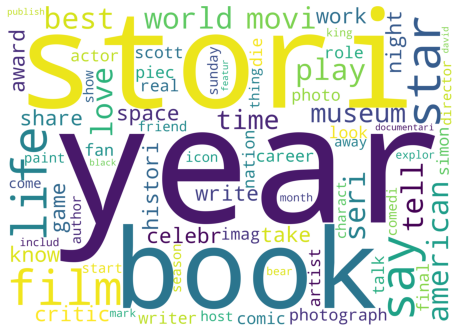


Wordcloud for topic: 1 



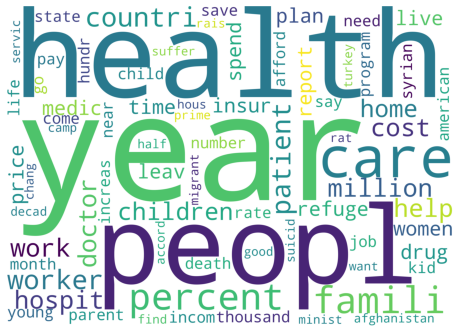


Wordcloud for topic: 2 



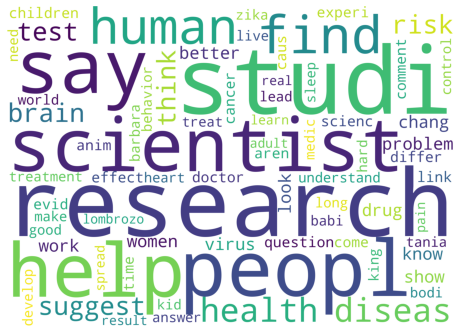


Wordcloud for topic: 3 



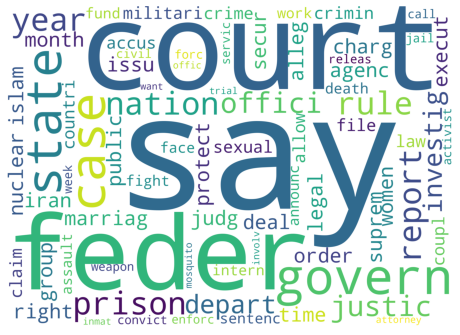


Wordcloud for topic: 4 



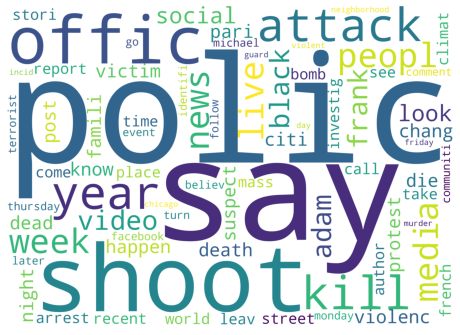


Wordcloud for topic: 5 



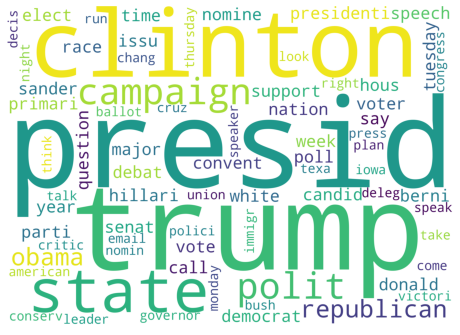


Wordcloud for topic: 6 



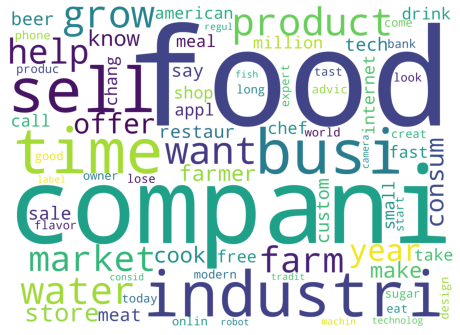


Wordcloud for topic: 7 



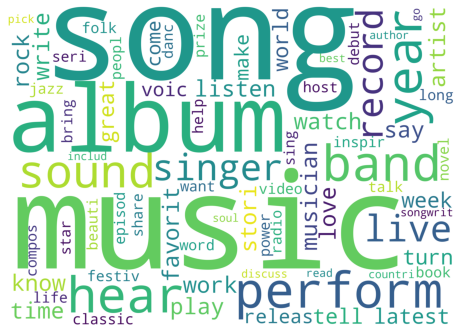


Wordcloud for topic: 8 



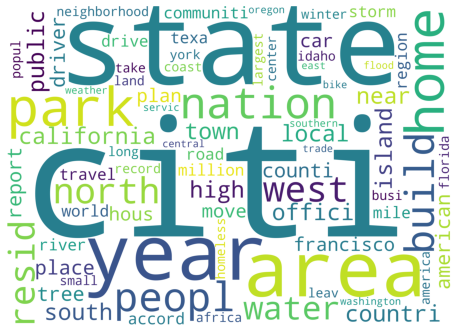


Wordcloud for topic: 9 



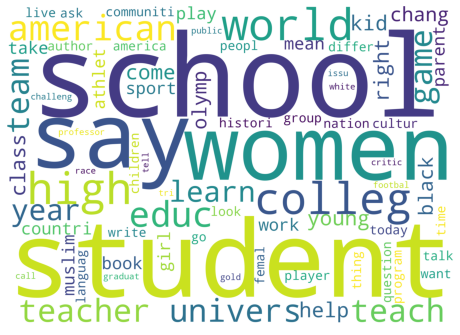

In [75]:
for topic in range(10):
    #plt.figure(figsize=(10,15))
    word_cloud(topic, lda_model)


Wordcloud for topic: 0 



<Figure size 720x1080 with 0 Axes>

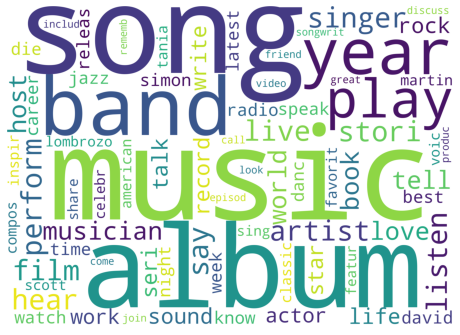


Wordcloud for topic: 1 



<Figure size 720x1080 with 0 Axes>

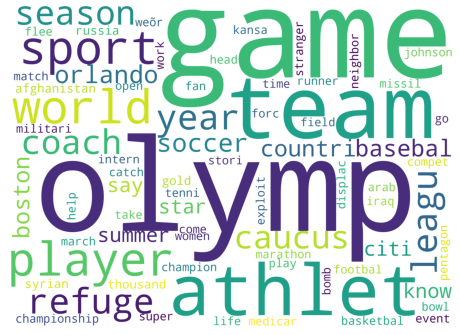


Wordcloud for topic: 2 



<Figure size 720x1080 with 0 Axes>

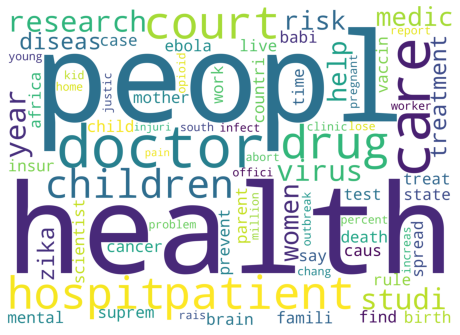


Wordcloud for topic: 3 



<Figure size 720x1080 with 0 Axes>

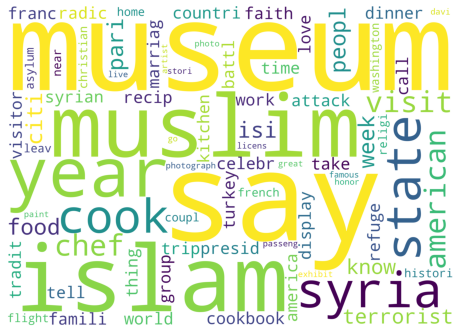


Wordcloud for topic: 4 



<Figure size 720x1080 with 0 Axes>

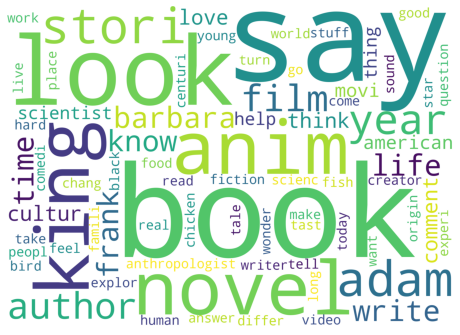


Wordcloud for topic: 5 



<Figure size 720x1080 with 0 Axes>

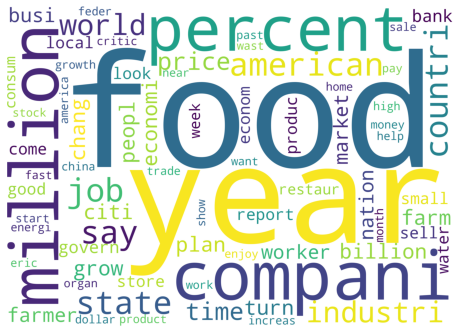


Wordcloud for topic: 6 



<Figure size 720x1080 with 0 Axes>

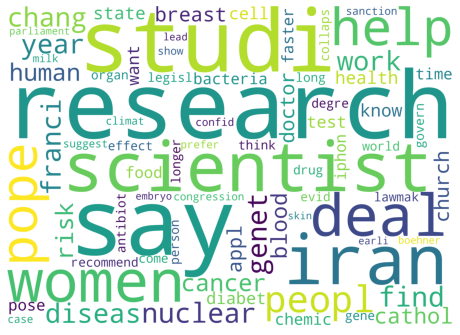


Wordcloud for topic: 7 



<Figure size 720x1080 with 0 Axes>

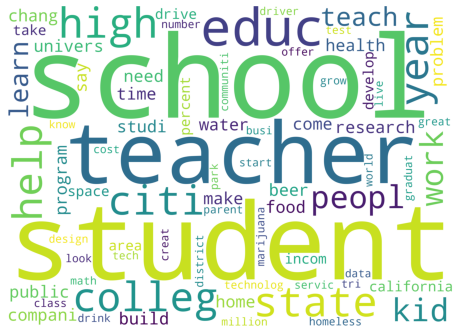


Wordcloud for topic: 8 



<Figure size 720x1080 with 0 Axes>

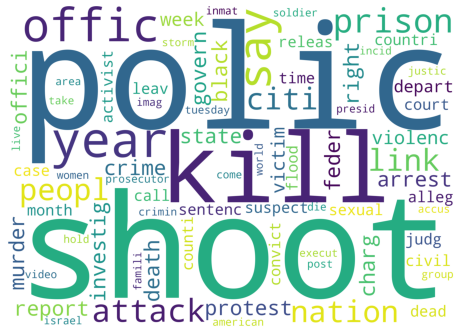


Wordcloud for topic: 9 



<Figure size 720x1080 with 0 Axes>

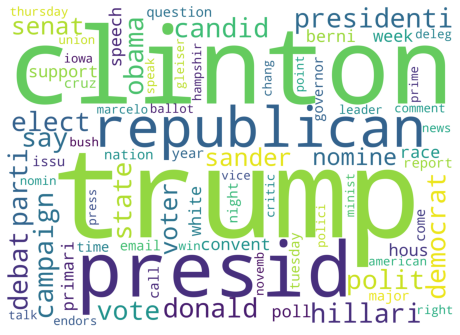

In [76]:
for topic in range(10):
    plt.figure(figsize=(10,15))
    word_cloud(topic, lda_model_tfidf)